In [116]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.tuner import Tuner
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, AutoRegressiveBaseModel,AutoRegressiveBaseModelWithCovariates
from pytorch_forecasting.metrics import MAE,RMSE,QuantileLoss
import os
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from pytorch_forecasting.models.nn import LSTM
from typing import Dict
from sklearn.preprocessing import StandardScaler
import random

In [117]:
stream = pd.read_pickle('/content/stream_processed.pkl',compression= 'zip')
meteo = pd.read_pickle('/content/meteo_processed.pkl',compression = 'zip')
stream

measurement_location,Datum,15202300,15205501,15207507,15210206,15212008,15212700,15213500,15214003,15214604,15216009,15217908,15221009,15228008,15241006,15242304,15243001,15246000,15247002,15247501
0,2014-01-01,14.4,17.2,19.8,3.87,8.66,9.66,0.433,2.35,0.207,1.66,0.921,0.671,2.59,0.253,0.870,1.26,2.35,0.355,0.120
1,2014-01-02,14.4,17.0,19.3,3.78,8.52,9.46,0.435,2.51,0.204,1.62,0.909,0.664,2.57,0.253,0.870,1.23,2.32,0.361,0.131
2,2014-01-03,14.1,16.6,19.3,3.78,8.40,9.42,0.429,2.61,0.201,1.60,0.907,0.641,2.58,0.253,0.871,1.23,2.30,0.362,0.130
3,2014-01-04,14.2,16.6,19.3,3.84,8.57,9.50,0.445,2.49,0.214,1.64,0.935,0.642,2.60,0.256,0.929,1.26,2.44,0.382,0.127
4,2014-01-05,16.4,18.4,20.6,4.36,9.94,10.80,0.545,2.86,0.267,1.80,1.130,0.690,3.10,0.300,1.150,1.61,3.14,0.561,0.175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3648,2023-12-28,79.7,102.0,120.0,28.50,46.20,57.10,1.900,17.30,0.721,10.30,6.070,3.920,12.20,0.786,3.270,9.05,12.50,2.020,0.741
3649,2023-12-29,71.4,82.5,97.7,26.00,41.90,51.30,1.710,15.60,0.801,9.85,5.480,3.470,10.90,0.653,2.890,7.23,9.97,1.750,0.619
3650,2023-12-30,64.0,71.4,86.3,24.40,38.60,46.90,1.530,14.70,0.835,9.40,4.900,3.100,9.77,0.557,2.550,5.92,8.54,1.470,0.514
3651,2023-12-31,59.1,63.0,77.3,22.20,35.30,42.50,1.410,13.10,0.669,8.83,4.480,2.670,8.92,0.492,2.330,5.40,7.66,1.290,0.458


In [118]:
stream[list(stream.columns[1:])] = stream[list(stream.columns[1:])].rolling(window=3).mean()

In [119]:
def mean_meteo(df : pd.DataFrame,meteo : str):
    in_df = df.copy()[[col for col in df.columns if meteo in col]]
    return in_df.mean(axis = 1)

In [120]:

meteo_vars = ['t2m','tp','ssr','d2m','sp']

for var in meteo_vars:
    meteo[f"mean_{var}"] = mean_meteo(meteo,var)

tp_to_drop = [col for col in meteo.columns if 'tp_' in col]
d2m_to_drop = [col for col in meteo.columns if 'd2m_' in col]
ssr_to_drop = [col for col in meteo.columns if 'ssr_' in col]
t2m_to_drop = [col for col in meteo.columns if 't2m_' in col]
sp_tp_drop = [col for col in meteo.columns if 'sp_' in col]
cols_to_drop = tp_to_drop + d2m_to_drop + ssr_to_drop + t2m_to_drop + sp_tp_drop
meteo = meteo.drop(columns = cols_to_drop)
meteo[['mean_t2m','mean_tp','mean_ssr','mean_d2m','mean_sp']] = meteo[['mean_t2m','mean_tp','mean_ssr','mean_d2m','mean_sp']].rolling(3).mean()
meteo = meteo.dropna()
meteo.head()

,date,mean_t2m,mean_tp,mean_ssr,mean_d2m,mean_sp
2,2014-01-03,273.021965,0.000003,119146.173438,271.883361,95313.604938
3,2014-01-04,274.925370,0.000063,126557.485226,273.071493,95113.810892
4,2014-01-05,275.965074,0.000089,101905.371445,274.455001,95083.448483
5,2014-01-06,276.129214,0.000097,99399.849663,274.637074,95148.867959
6,2014-01-07,276.075047,0.000038,114978.027700,274.781352,95473.672910


In [121]:
stream = stream.iloc[:3652]
meteo = meteo.drop(columns = 'date')
data = stream.join(meteo).drop(columns = 'Datum').dropna()
data['groups'] = 0
data['date'] = data.index
data

,15202300,15205501,15207507,15210206,15212008,15212700,15213500,15214003,15214604,15216009,...,15246000,15247002,15247501,mean_t2m,mean_tp,mean_ssr,mean_d2m,mean_sp,groups,date
2,14.300000,16.933333,19.466667,3.810000,8.526667,9.513333,0.432333,2.490000,0.204000,1.626667,...,2.323333,0.359333,0.127000,273.021965,0.000003,119146.173438,271.883361,95313.604938,0,2
3,14.233333,16.733333,19.300000,3.800000,8.496667,9.460000,0.436333,2.536667,0.206333,1.620000,...,2.353333,0.368333,0.129333,274.925370,0.000063,126557.485226,273.071493,95113.810892,0,3
4,14.900000,17.200000,19.733333,3.993333,8.970000,9.906667,0.473000,2.653333,0.227333,1.680000,...,2.626667,0.435000,0.144000,275.965074,0.000089,101905.371445,274.455001,95083.448483,0,4
5,16.300000,18.800000,21.433333,4.193333,9.736667,10.600000,0.504667,2.740000,0.239333,1.740000,...,2.866667,0.477000,0.152667,276.129214,0.000097,99399.849663,274.637074,95148.867959,0,5
6,16.733333,19.800000,22.966667,4.260000,10.083333,10.900000,0.515333,2.776667,0.241000,1.750000,...,2.963333,0.493333,0.156000,276.075047,0.000038,114978.027700,274.781352,95473.672910,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647,139.733333,211.000000,240.000000,45.500000,79.500000,100.166667,3.023333,32.000000,2.451000,12.270000,...,23.933333,3.910000,1.762000,279.720414,0.000105,43848.074041,276.986864,95735.617496,0,3647
3648,100.966667,150.000000,172.666667,33.833333,56.900000,71.533333,2.296667,22.633333,1.164667,10.370000,...,17.433333,2.633333,1.035667,278.115081,0.000021,75076.971920,275.530633,95956.563242,0,3648
3649,82.100000,107.500000,126.233333,29.033333,47.366667,58.733333,1.940000,18.133333,0.838333,10.020000,...,13.023333,2.100000,0.772000,278.131672,0.000016,113272.033552,275.687857,95952.454680,0,3649
3650,71.700000,85.300000,101.333333,26.300000,42.233333,51.766667,1.713333,15.866667,0.785667,9.850000,...,10.336667,1.746667,0.624667,278.368488,0.000021,120318.203430,275.602084,95795.413570,0,3650


In [122]:
max_pred_len = 3
enc_len = 364
# training_cutoff = int(data["date"].max()*0.7) - max_pred_len
val_cutoff = int(data["date"].max()*0.15) - max_pred_len
test_cutoff = int(data["date"].max()*0.3)- max_pred_len

training = TimeSeriesDataSet(
    data= data.iloc[test_cutoff:],
    target='15207507',#'15207507'
    group_ids=['groups'],#groups
    time_idx='date',#date
    min_prediction_idx=test_cutoff,
    max_encoder_length=enc_len,
    min_encoder_length=enc_len,
    min_prediction_length=max_pred_len,
    max_prediction_length=max_pred_len,
    time_varying_unknown_reals=['15207507'],
    time_varying_known_reals=['mean_t2m','mean_tp']#data.columns[20:-1].values.tolist(),
)

validation = TimeSeriesDataSet.from_dataset(training,data.iloc[: val_cutoff],min_prediction_idx=0,stop_randomization=True)

train_dataloader = training.to_dataloader(train=True, batch_size=128, num_workers=2)
val_dataloader = validation.to_dataloader(train=False, batch_size=64, num_workers=2)


In [123]:

tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.003,
    hidden_size=128,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=2,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=64,  # set to <= hidden_size
    loss=MAE(),
    optimizer="adam",
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience = 7,
    reduce_on_plateau_min_lr = 0.00003,
    weight_decay = 0.0001
    )

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [124]:
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=80,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [125]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 384    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 0      | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 78.2 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 52.0 K | train
7  | static_context_variable_selectio

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=80` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=80` reached.


In [126]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [127]:
test = TimeSeriesDataSet.from_dataset(training,data[:test_cutoff-2],min_prediction_idx= val_cutoff,stop_randomization=True)
test_dataloader = test.to_dataloader(train=False, batch_size=1, num_workers=2)
len(test)

546

In [128]:
predictions = best_tft.predict(test_dataloader,return_y=True,trainer_kwargs=dict(accelerator="cpu"))

INFO: GPU available: True (cuda), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.

In [129]:
def kge(inputs,targets):
    r = torch.corrcoef(torch.stack((inputs.squeeze(),targets)))[0][1]
    alpha = inputs.std()/targets.std()
    beta = inputs.mean()/targets.mean()
    kge = torch.sqrt(torch.square(r-1) + torch.square(alpha-1) + torch.square(beta-1))
    return 1 - kge

In [130]:
true_y = predictions.y[0].reshape((len(test),max_pred_len))
results = {}
for i in range(predictions.output.size(1)):
    results[f"lag: {i+1}"] = kge(true_y[:,i],predictions.output[:,i])
results

{'lag: 1': tensor(0.9595), 'lag: 2': tensor(0.8037), 'lag: 3': tensor(0.6632)}

In [131]:
#save results
pd.DataFrame(results,index=[0]).to_csv(os.path.join('..','content',f"lead_time_{max_pred_len}_results.csv"))


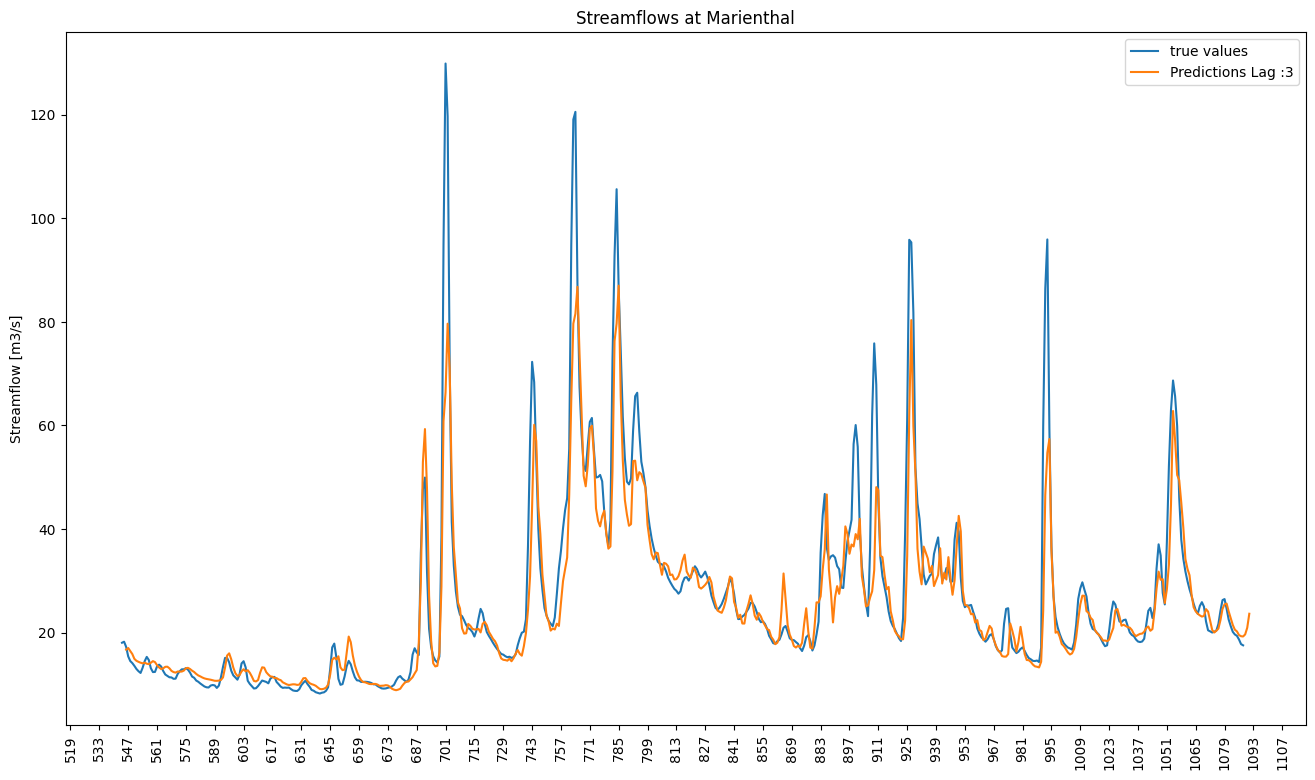

In [132]:
import matplotlib.dates as mdates


# stream_plot = stream.set_index('Datum')
stream_plot = stream.copy()
# predictions_np = predictions.output[:,max_pred_len-1].numpy()#[:,max_pred_len-1]
# true_values_np = predictions.y[0].view(-1, 1).squeeze().numpy()

# Plotting

plt.figure(figsize=(16, 9))


plt.plot(stream_plot.index[val_cutoff:test_cutoff- max_pred_len],stream_plot['15207507'].iloc[val_cutoff :test_cutoff - max_pred_len].values,  label = 'true values')

for i in range(max_pred_len-1,predictions.output.size(1),1):
    predictions_np = predictions.output[:,i].numpy()
    plt.plot(stream_plot.index[val_cutoff+i : test_cutoff - max_pred_len+1+i],predictions_np, label=f"Predictions Lag :{i+1}")



plt.ylabel('Streamflow [m3/s]')
plt.title('Streamflows at Marienthal')

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [133]:
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True,trainer_kwargs=dict(accelerator="cpu"))

INFO: GPU available: True (cuda), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


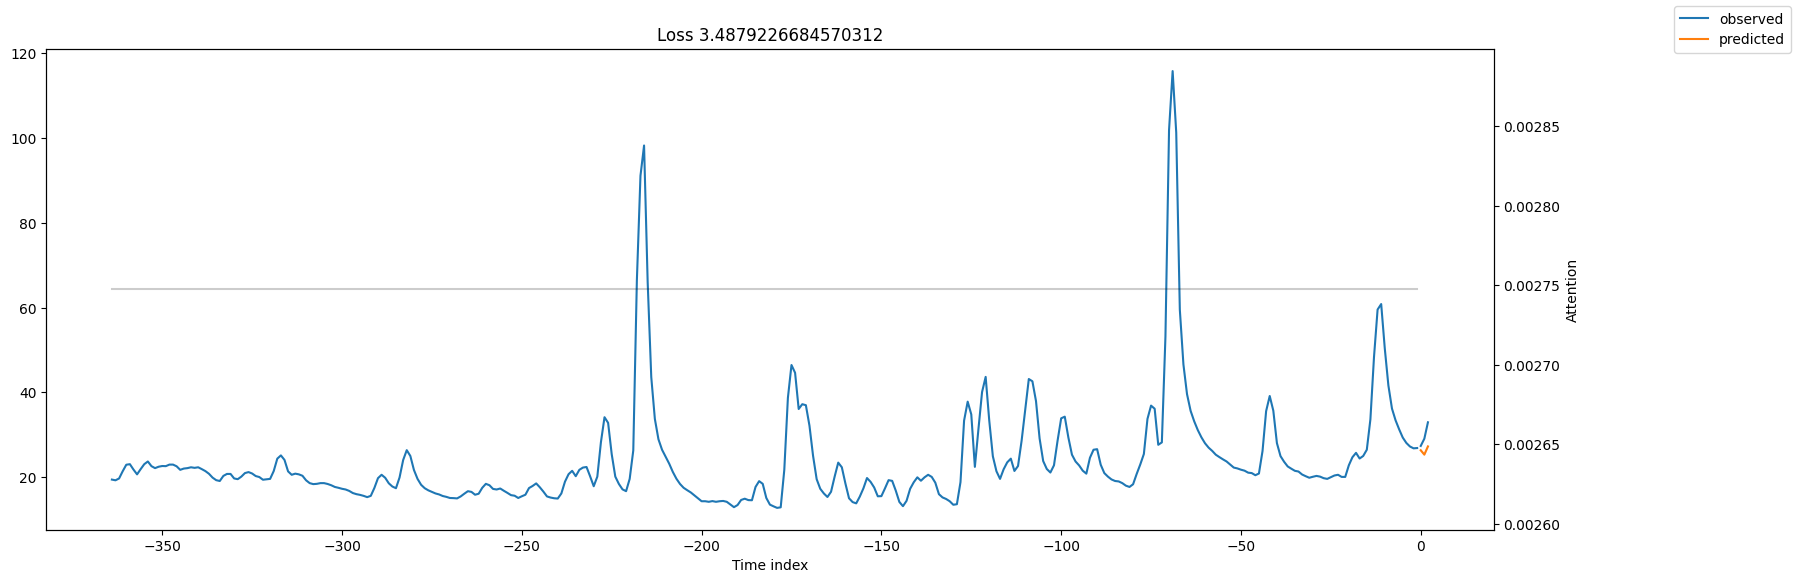

In [134]:
fig = best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=0, add_loss_to_title=True)
fig.set_size_inches(19, 6)
plt.show()

INFO: GPU available: True (cuda), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


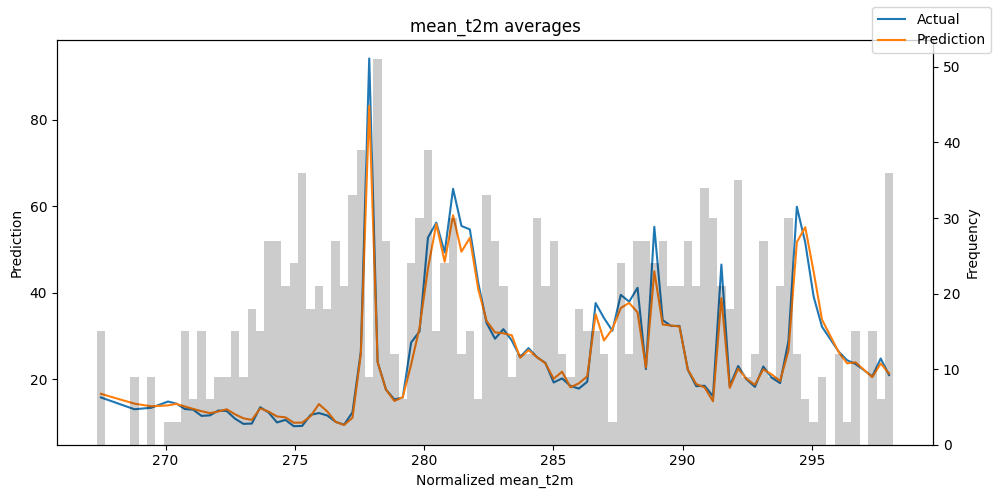

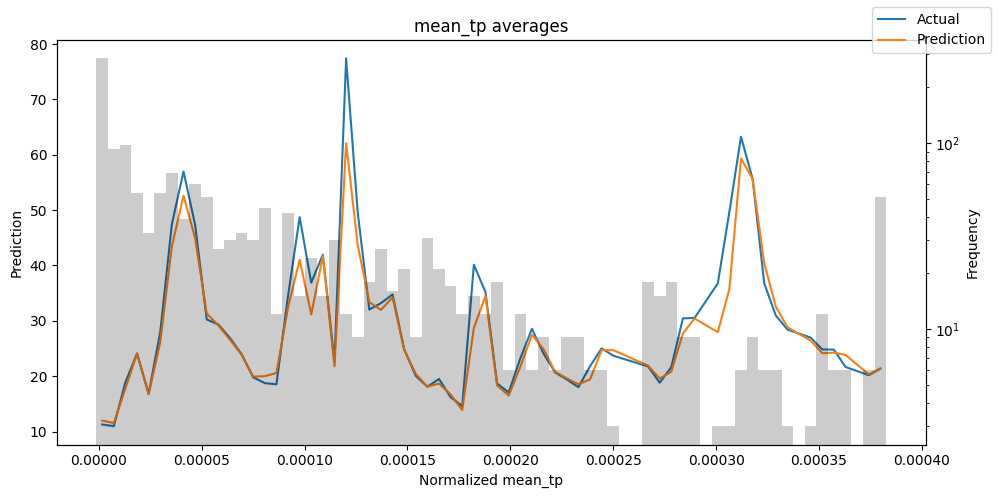

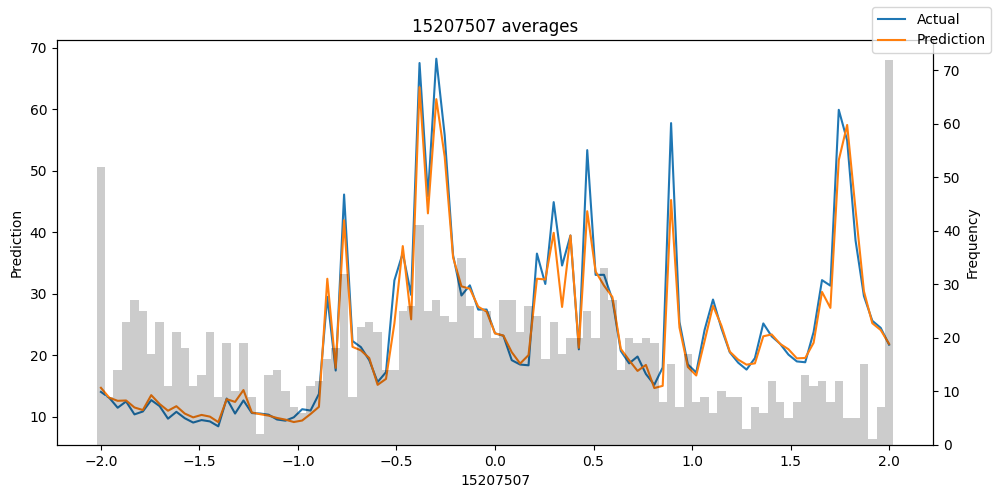

In [135]:
predictions = best_tft.predict(test_dataloader, return_x=True,trainer_kwargs=dict(accelerator="cpu"))
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
fig = best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)
plt.show()

In [136]:
predictions_vs_actuals.keys()

dict_keys(['support', 'average', 'std'])

(array([397., 816., 702., 453., 354., 244., 177., 123.,  86.,  63.,  61.,
         31.,  22.,  23.,  12.,  16.,  16.,  12.,   2.,   9.,   3.,   4.,
          4.,   3.,   2.,   2.,   3.,   1.,   1.,   2.,   0.,   0.,   1.,
          0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   1.]),
 array([  7.52      ,  13.16293333,  18.80586667,  24.4488    ,
         30.09173333,  35.73466667,  41.3776    ,  47.02053333,
         52.66346667,  58.3064    ,  63.94933333,  69.59226667,
         75.2352    ,  80.87813333,  86.52106667,  92.164     ,
         97.80693333, 103.44986667, 109.0928    , 114.73573333,
        120.37866667, 126.0216    , 131.66453333, 137.30746667,
        142.9504    , 148.59333333, 154.23626667, 159.8792    ,
        165.52213333, 171.16506667, 176.808     , 182.45093333,
        188.09386667, 193.7368    , 199.37973333, 205.02266667,
        210.6656    , 216.30853333, 221.95146667, 227.5944    ,
        233.237333

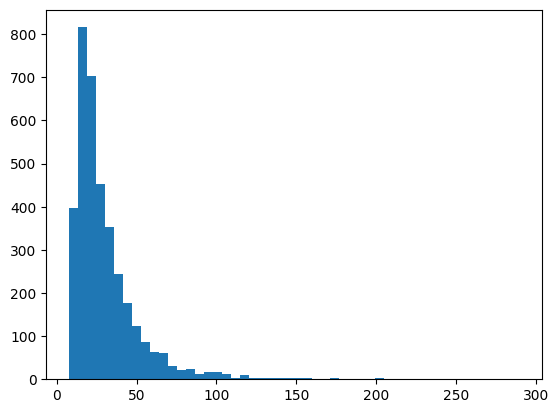

In [137]:
plt.hist(stream['15207507'],bins=50)

(array([  2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   1.,
          1.,   1.,   1.,   1.,   2.,   0.,   0.,   2.,   1.,   3.,   1.,
          1.,   4.,   3.,   8.,   4.,   3.,  10.,  10.,  14.,  19.,  32.,
         80., 166., 123.,  19.,  11.,   9.,   2.,   1.,   2.,   3.,   1.,
          1.,   0.,   1.,   0.,   0.,   1.]),
 array([-50.23389994, -48.78284392, -47.3317879 , -45.88073188,
        -44.42967586, -42.97861984, -41.52756382, -40.0765078 ,
        -38.62545178, -37.17439576, -35.72333974, -34.27228372,
        -32.8212277 , -31.37017168, -29.91911566, -28.46805964,
        -27.01700362, -25.5659476 , -24.11489158, -22.66383556,
        -21.21277954, -19.76172352, -18.3106675 , -16.85961148,
        -15.40855546, -13.95749944, -12.50644342, -11.0553874 ,
         -9.60433138,  -8.15327536,  -6.70221934,  -5.25116332,
         -3.8001073 ,  -2.34905128,  -0.89799526,   0.55306076,
          2.00411678,   3.4551728 ,   4.90622882,   6.35728484,
          7.808340

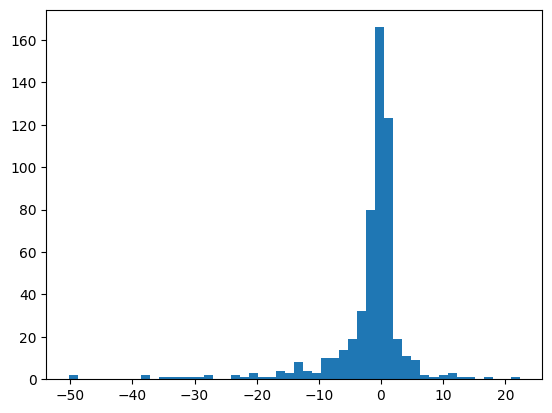

In [138]:
#plot residuals
plt.hist(predictions.output[:,max_pred_len-1] - stream['15207507'].iloc[val_cutoff + max_pred_len - 1 - 1:test_cutoff -1].values,bins = 50)

In [139]:
tp_dependency = best_tft.predict_dependency(
    val_dataloader.dataset, "mean_tp", np.linspace(0, 0.0005, 50), show_progress_bar=True, mode="dataframe"
)

Predict:   0%|          | 0/50 [00:00<?, ? batches/s]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU

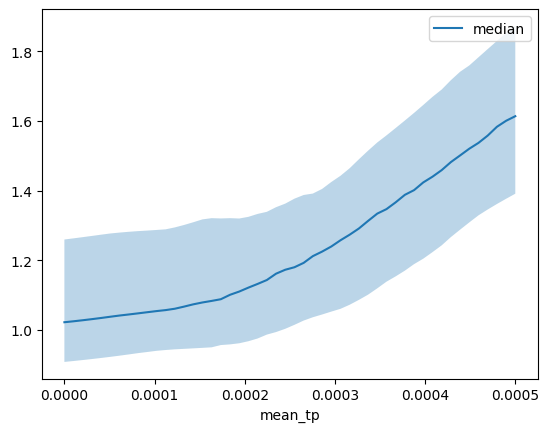

In [140]:
# plotting median and 25% and 75% percentile
agg_tp_dependency = tp_dependency.groupby("mean_tp").normalized_prediction.agg(
    median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)
)
ax = agg_tp_dependency.plot(y="median")
ax.fill_between(agg_tp_dependency.index, agg_tp_dependency.q25, agg_tp_dependency.q75, alpha=0.3)

In [141]:
dependency = best_tft.predict_dependency(
    val_dataloader.dataset, "mean_t2m", np.linspace(265, 300, 50), show_progress_bar=True, mode="dataframe"
)

Predict:   0%|          | 0/50 [00:00<?, ? batches/s]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU

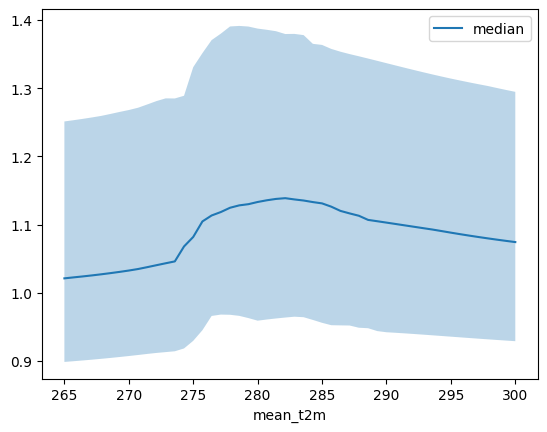

In [142]:
# plotting median and 25% and 75% percentile
agg_dependency = dependency.groupby("mean_t2m").normalized_prediction.agg(
    median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)
)
ax = agg_dependency.plot(y="median")
ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.3)